In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as st
from scipy.stats import skew

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from pathlib import Path
from typing import Union

from visualization import *
from choose_best_t1w import *
from stats_plot import *

In [2]:
%load_ext autoreload
%autoreload 2

In [22]:
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

root_dir = cfg["root_dir"]
pattern = cfg["pattern"]
label_index = cfg["label_index"]
roi_volumes_csv = cfg["roi_volumes_csv"]
roi_volumes_csv_z = cfg["roi_volumes_z_csv"]
roi_volumes_csv00 = cfg["roi_volumes_ses00_csv"]
roi_volumes_csv12 = cfg["roi_volumes_ses12_csv"]
roi_volumes_csv00_z = cfg["roi_volumes_ses00_z_csv"]
roi_volumes_csv12_z = cfg["roi_volumes_ses12_z_csv"]
roi_volumes_delta_pct_csv = cfg["roi_volumes_delta_pct_csv"]

In [ ]:
CELL_THR = 2.0
SUB_THR = 5
ROI_FRAC_THR = 0.05
MAX_ROI_SHOW = 12

zdf = pd.read_csv(roi_volumes_csv_z).set_index("subject").apply(pd.to_numeric)

mask = zdf.abs() >= CELL_THR

print("\n================ Cell-level ==================")
print(
    f"Total cells |z| ≥ {CELL_THR}: {mask.values.sum()} "
    f" / {zdf.size}  ({mask.values.mean():.2%})"
)

print("\n================ Subject-level (≥{SUB_THR} ROI) ================")
sids = []
for sid, cnt in mask.sum(axis=1).sort_values(ascending=False).items():
    if cnt >= SUB_THR:
        rois = zdf.columns[mask.loc[sid]]
        zs = zdf.loc[sid, rois]
        roi_str = ", ".join(f"{r}({zs[r]:+.1f})" for r in rois[:MAX_ROI_SHOW])
        tail = " ..." if len(rois) > MAX_ROI_SHOW else ""
        print(f"{sid:30s}  {cnt:3d} ROI  →  {roi_str}{tail}")
        sids.append(sid)

print(f"\n================ ROI-level (≥{ROI_FRAC_THR:.0%} subjects) ================")
for roi, frac in mask.mean().sort_values(ascending=False).items():
    if frac >= ROI_FRAC_THR:
        n = int(frac * len(zdf))
        print(f"{roi:25s}  {n:3d}/{len(zdf):3d} subjects  ({frac:.1%})")

for subjectid in sids:
    print(f"subject = {subjectid}")
    visualize_slant_subjectid(subjectid, run_number=2, bg_t1_file=True)
    visualize_t1w_subjectid(subjectid, run_number=1)
    visualize_t1w_subjectid(subjectid, run_number=2)

In [ ]:
visualize_slant_subjectid(
    "sub-BRA012_ses-00",
    axial_slices=(150, 154, 158, 162, 166, 170),
    keep_roi_list=[51, 52],
    bg_t1_file=True,
)

In [ ]:
visualize_slant_subjectid(
    "sub-BRA012_ses-12",
    coronal_slices=(123),
    axial_slices=(120),
    keep_roi_list=[49, 50],
    bg_t1_file=True,
)

In [13]:
vdf_00 = pd.read_csv(roi_volumes_csv00)
vdf_12 = pd.read_csv(roi_volumes_csv12)
plot_roi_compare(vdf_00, vdf_12, 4)
plot_roi_compare(vdf_00, vdf_12, 51)
plot_roi_compare(vdf_00, vdf_12, 52)

Saved stats_png/3rd-Ventricle_vol_distribution.png
Saved stats_png/Right-Lateral-Ventricle_vol_distribution.png
Saved stats_png/Left-Lateral-Ventricle_vol_distribution.png


In [24]:
df00 = pd.read_csv(roi_volumes_csv00, index_col="subject")
df12 = pd.read_csv(roi_volumes_csv12, index_col="subject")
df00.index = df00.index.to_series().str.split("_ses-").str[0]
df12.index = df12.index.to_series().str.split("_ses-").str[0]

common_idx = df00.index.intersection(df12.index)
df00 = df00.loc[common_idx]
df12 = df12.loc[common_idx]

delta_pct = (df12 - df00) / df00 * 100
delta_pct.index.name = "subject"

delta_pct = delta_pct.sort_index(axis=1)

delta_pct.to_csv(roi_volumes_delta_pct_csv, float_format="%.6f")
print(f"Δ% per ROI saved to {roi_volumes_delta_pct_csv}   shape={delta_pct.shape}")

Δ% per ROI saved to stats_csv/roi_volumes_delta_pct.csv   shape=(34, 135)


In [34]:
delta_pct = pd.read_csv(roi_volumes_delta_pct_csv)
plot_delta_bar(delta_pct, 4, cmap_name="RdBu_r")
plot_delta_bar(delta_pct, 51, cmap_name="RdBu_r")
plot_delta_bar(delta_pct, 52, cmap_name="RdBu_r")
plot_delta_hist_kde(delta_pct, 4, bins=10)
plot_delta_hist_kde(delta_pct, 51, bins=10)
plot_delta_hist_kde(delta_pct, 52, bins=10)

Saved stats_png/3rd-Ventricle_delta_pct.png
Saved stats_png/Right-Lateral-Ventricle_delta_pct.png
Saved stats_png/Left-Lateral-Ventricle_delta_pct.png
Saved stats_png/3rd-Ventricle_delta_hist_kde.png
Saved stats_png/Right-Lateral-Ventricle_delta_hist_kde.png
Saved stats_png/Left-Lateral-Ventricle_delta_hist_kde.png


In [9]:
col = "L51"
tstat, p = st.ttest_rel(df12[col], df00[col])
d = (df12[col] - df00[col]).mean() / (df12[col] - df00[col]).std(ddof=1)
print(f"t = {tstat:.2f}, p = {p:.4f}, Cohen d = {d:.2f}")

t = -2.39, p = 0.0225, Cohen d = -0.41


In [ ]:
df00 = pd.read_csv(roi_volumes_csv00, index_col="subject")
df12 = pd.read_csv(roi_volumes_csv12, index_col="subject")

df00.index = df00.index.str.split("_ses-").str[0]
df12.index = df12.index.str.split("_ses-").str[0]

common = df00.index.intersection(df12.index)
df00, df12 = df00.loc[common], df12.loc[common]

delta = (df12 - df00) / df00 * 100

rows = []
for col in delta.columns:
    d = delta[col].dropna()
    if d.empty:
        continue
    mean, sd, median = d.mean(), d.std(ddof=1), d.median()
    n_up = (d > 0).sum()
    n_down = (d <= 0).sum()

    sh_p = st.shapiro(d)[1] if len(d) >= 3 else np.nan
    if sh_p > 0.05:
        t, p = st.ttest_rel(df12[col], df00[col])
        cohend = (d.mean()) / d.std(ddof=1)
        test, eff, eff_name = "paired_t", cohend, "cohen_d"
    else:
        w, p = st.wilcoxon(df12[col], df00[col], zero_method="wilcox")
        z = st.norm.ppf(p / 2) * (-1 if w > len(d) * (len(d) + 1) / 4 else 1)
        rho = z / np.sqrt(len(d))
        test, eff, eff_name = "wilcoxon", rho, "rho"

    rows.append(
        {
            "ROI": col,
            "mean_%": f"{mean:+.2f}",
            "sd_%": f"{sd:.2f}",
            "median_%": f"{median:+.2f}",
            "n_up": n_up,
            "n_down": n_down,
            "normal_p": f"{sh_p:.3f}",
            "test": test,
            "p": f"{p:.4g}",
            eff_name: f"{eff:.2f}",
        }
    )

stats_df = pd.DataFrame(rows).set_index("ROI")
stats_df.to_csv("stats_csv/roi_volume_delta_pct_stats.csv")
print(stats_df)

/home/local/VANDERBILT/lij112/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/local/VANDERBILT/lij112/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/local/VANDERBILT/lij112/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/local/VANDERBILT/lij112/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are ze

      mean_%    sd_% median_%  n_up  n_down normal_p      test        p  \
ROI                                                                       
L0     +4.41    8.35    +0.04    21      13    0.000  wilcoxon  0.02167   
L4     -2.07   13.91    -1.17    14      20    0.394  paired_t   0.1543   
L11    -3.52   13.17    -3.45     9      25    0.016  wilcoxon   0.0238   
L23   +76.42  325.58    -0.48    16      18    0.000  wilcoxon   0.7681   
L30   +23.87   84.33    +3.09    20      14    0.000  wilcoxon   0.3482   
...      ...     ...      ...   ...     ...      ...       ...      ...   
L205   -0.00   12.63    +0.53    19      15    0.129  paired_t   0.6102   
L206   +0.73    6.49    +0.20    17      17    0.466  paired_t   0.3904   
L207   -0.45    5.01    +0.10    18      16    0.026  wilcoxon   0.8372   
L208   -1.86   14.24    -1.91    15      19    0.010  wilcoxon   0.2014   
L209   -2.44   14.56    -0.66    16      18    0.216  paired_t   0.1875   

        rho cohen_d  
RO

/home/local/VANDERBILT/lij112/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/local/VANDERBILT/lij112/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/local/VANDERBILT/lij112/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/local/VANDERBILT/lij112/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are ze

In [ ]:
roi_id = 52
col = f"L{roi_id}" if isinstance(roi_id, int) else str(roi_id)

if col not in delta.columns:
    raise KeyError(f"{col=} not found in delta DataFrame")

roi_delta = delta[col].dropna()

sub_max = roi_delta.idxmax()
sub_min = roi_delta.idxmin()
val_max = roi_delta.max()
val_min = roi_delta.min()

print(f"\nROI {col}:")
print(f"  Max Δ% = {val_max:+.2f}  (subject: {sub_max})")
print(f"  Min Δ% = {val_min:+.2f}  (subject: {sub_min})")

mean, sd = roi_delta.mean(), roi_delta.std(ddof=1)
upper_th = mean + 3 * sd
lower_th = mean - 3 * sd


def flag_outlier(value):
    return "  <== OUTLIER" if (value > upper_th or value < lower_th) else ""


print(f"  Mean ±3SD range: [{lower_th:+.2f}, {upper_th:+.2f}]")
print(f"  Max point: {flag_outlier(val_max)}")
print(f"  Min point: {flag_outlier(val_min)}")


ROI L52:
  Max Δ% = +23.50  (subject: sub-BRA033)
  Min Δ% = -21.45  (subject: sub-VUM013)
  Mean ±3SD range: [-31.22, +25.79]
  Max point: 
  Min point: 


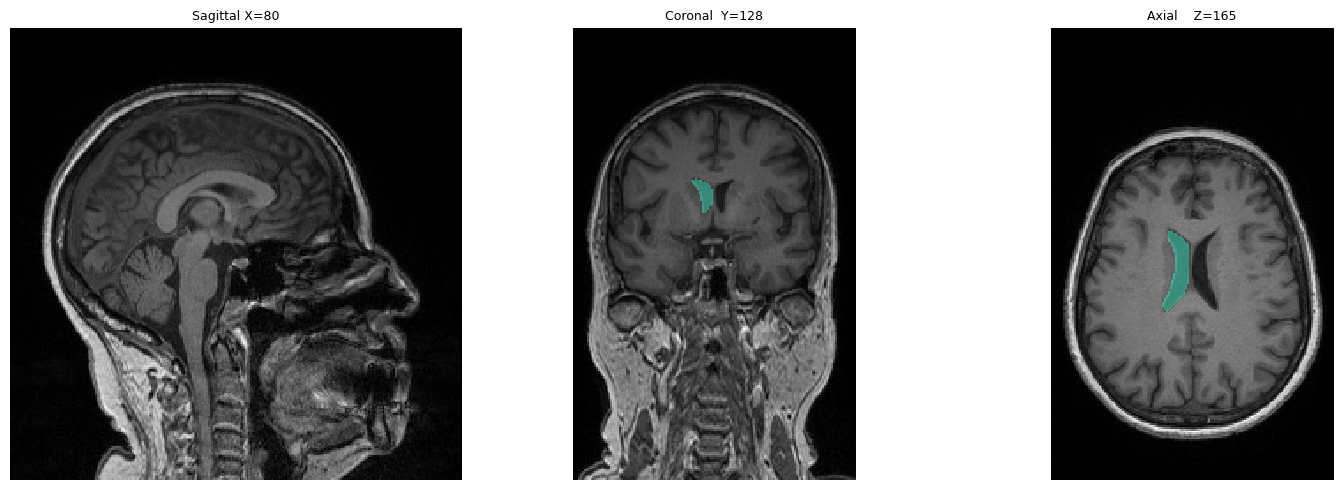

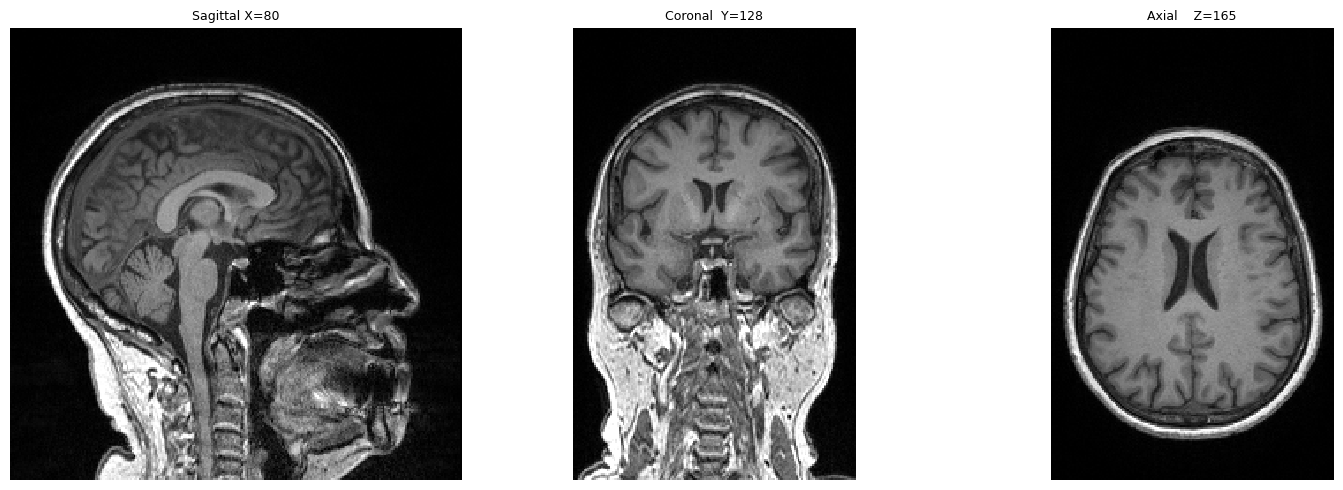

In [8]:
visualize_slant_subjectid(
    "sub-BRA033_ses-00", axial_slices=(165), keep_roi_list=(52), bg_t1_file=True
)
visualize_t1w_subjectid("sub-BRA033_ses-00", axial_slices=(165))

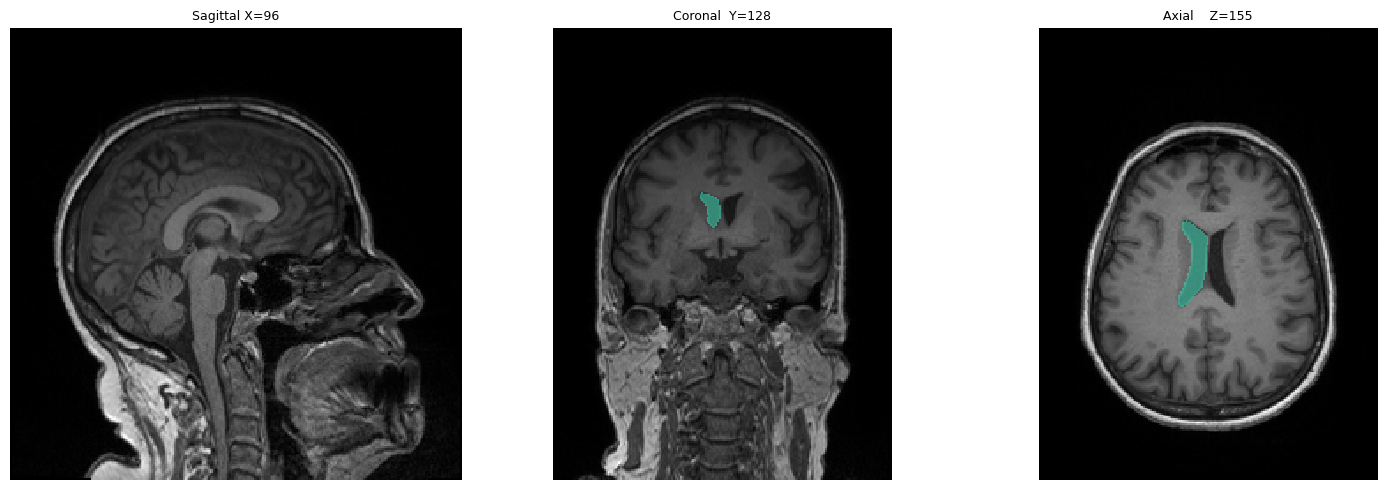

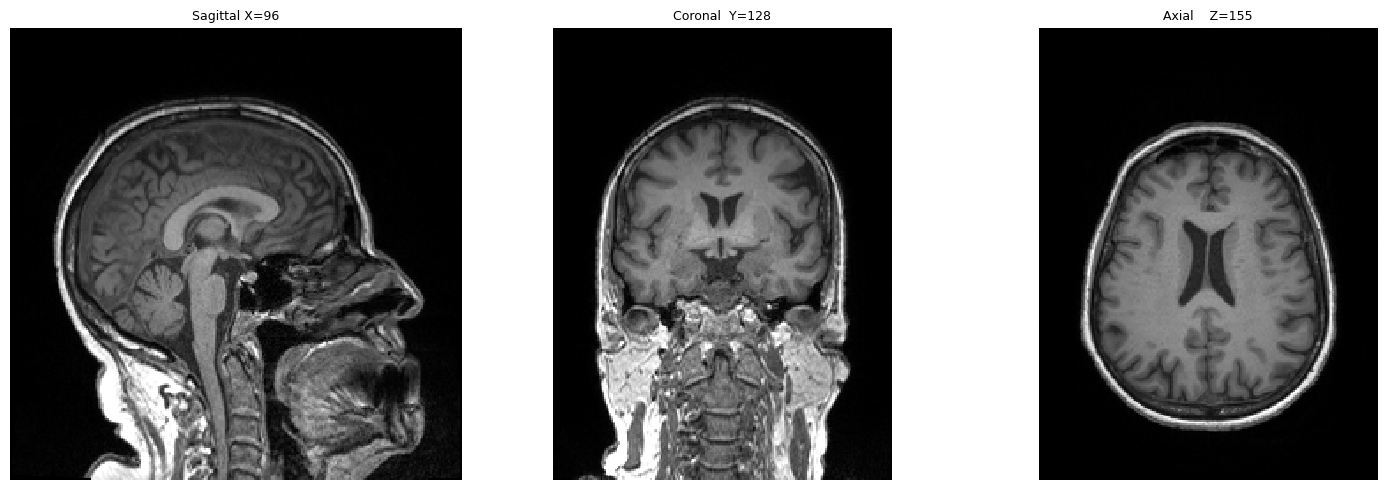

In [9]:
visualize_slant_subjectid(
    "sub-BRA033_ses-12", axial_slices=(155), keep_roi_list=(52), bg_t1_file=True
)
visualize_t1w_subjectid("sub-BRA033_ses-12", axial_slices=(155))

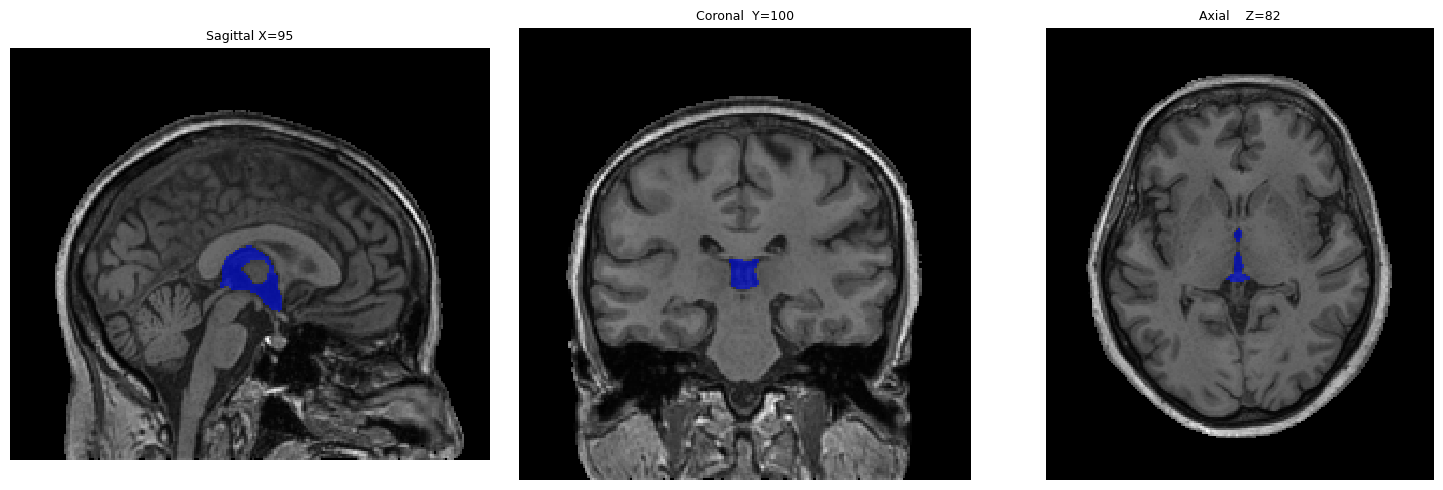

In [21]:
visualize_slant_subjectid(
    "sub-BRA033_ses-00", keep_roi_list=(4), auto_slice=True, bg_t1_file=True, show_img=False
)

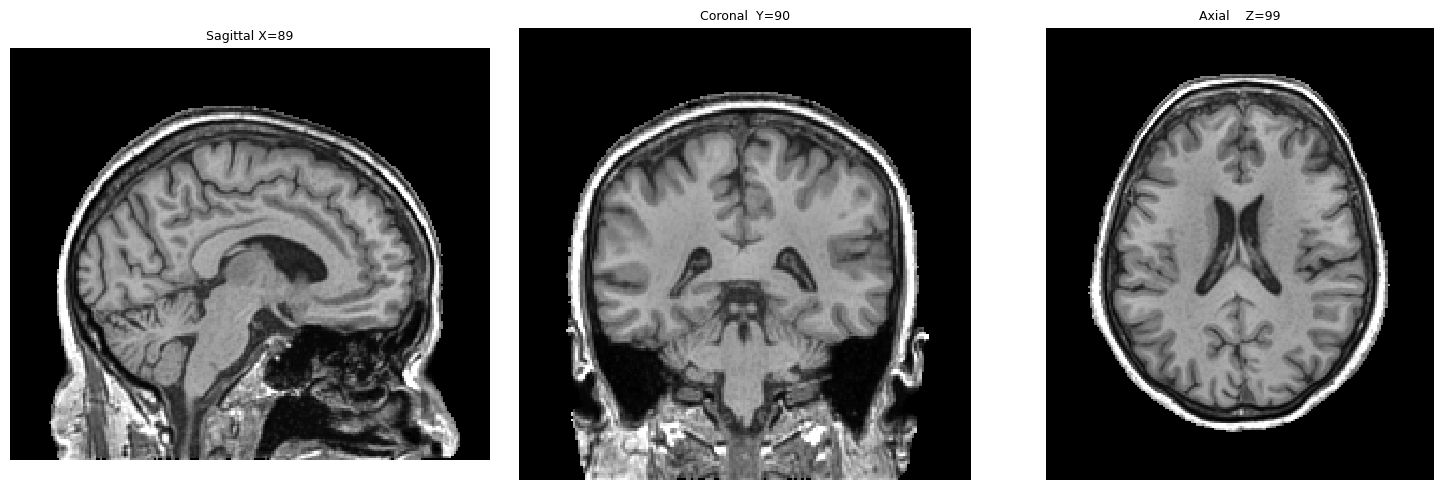

In [22]:
visualize_t1w_subjectid(
    "sub-BRA033_ses-12", sagittal_slices=(89), coronal_slices=(90), axial_slices=(99), show_img=False
)